<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-и-подготовка-данных" data-toc-modified-id="Обзор-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор и подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#Выводы:" data-toc-modified-id="Выводы:-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Выводы:</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси


Сервис по заказу такси собрал исторические данные о количестве заказов в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов на следующий час.

***Задача:***
* Построение модели для прогнозирования количества заказов такси на следующий час со значением метрики $RMSE <= 48$


## Обзор и подготовка данных


In [1]:
# импортируем необходимые для работы библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


In [2]:
# прочитаем и сохраним данные
# приведём признак с датами к типу данных 'datetime'
# используем его в качестве индекса
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])


In [3]:
# выведем информацию о располагаемых данных
print(f'\nОбъектов: {df.shape[0]}')
print(f'Признаков: {df.shape[1]}')
print(f'Пропусков: {df.isna().sum().sum()}')
print('\n\nПервые объекты и признаки:')
display(df.head())
print('\n\nОбщая информация о датафрейме:\n')
df.info()
print('\n\nОбщая статиска:\n')
df.describe().T



Объектов: 26496
Признаков: 1
Пропусков: 0


Первые объекты и признаки:


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32




Общая информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Общая статиска:



,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


In [4]:
# проверим, в хронологическом ли порядке расположены даты и время
df.index.is_monotonic


True

In [5]:
# выполним ресемплирование данных по одному часу
df = df.resample('1H').sum()
print('\nПервые объекты и признаки после ресемплирования:')
display(df.head())
print('\nОбщая статиска после ресемплирования:\n')
df.describe().T



Первые объекты и признаки после ресемплирования:


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43



Общая статиска после ресемплирования:



,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


### Выводы
1. В `df` представлены данные о заказах такси в аэропортах в период с начала марта по конец августа 2018 года;
1. После загрузки данные были ресемплированы с 10 мин. до 1 часа, соответственно количество признаков уменьшилось в 6 раз с 26 496 до 4 416;
1. Данные подготовлены для дальнейшего анализа.


## Анализ

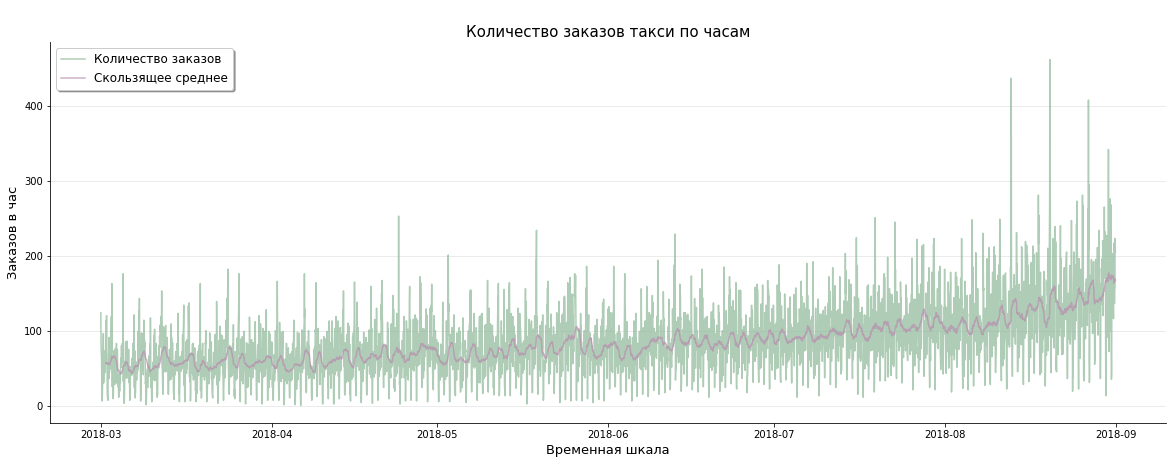

In [6]:
# построим график изменения количества заказов
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot()
ax.set_title('\nКоличество заказов такси по часам', size=15)
ax.set_xlabel('Временная шкала', size=13)
ax.set_ylabel('Заказов в час', size=13)

# наложим на него скользящее среднее с интервалом усреднения в 1 день (24 часа)
ax.plot(df['num_orders'], color='#8eb897', alpha=0.7, label='Количество заказов')
ax.plot(df.rolling(24).mean(), color='#b88eaf', alpha=0.7, label='Скользящее среднее')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.3)
ax.legend(loc='best', fontsize='large', shadow=True)

plt.show()


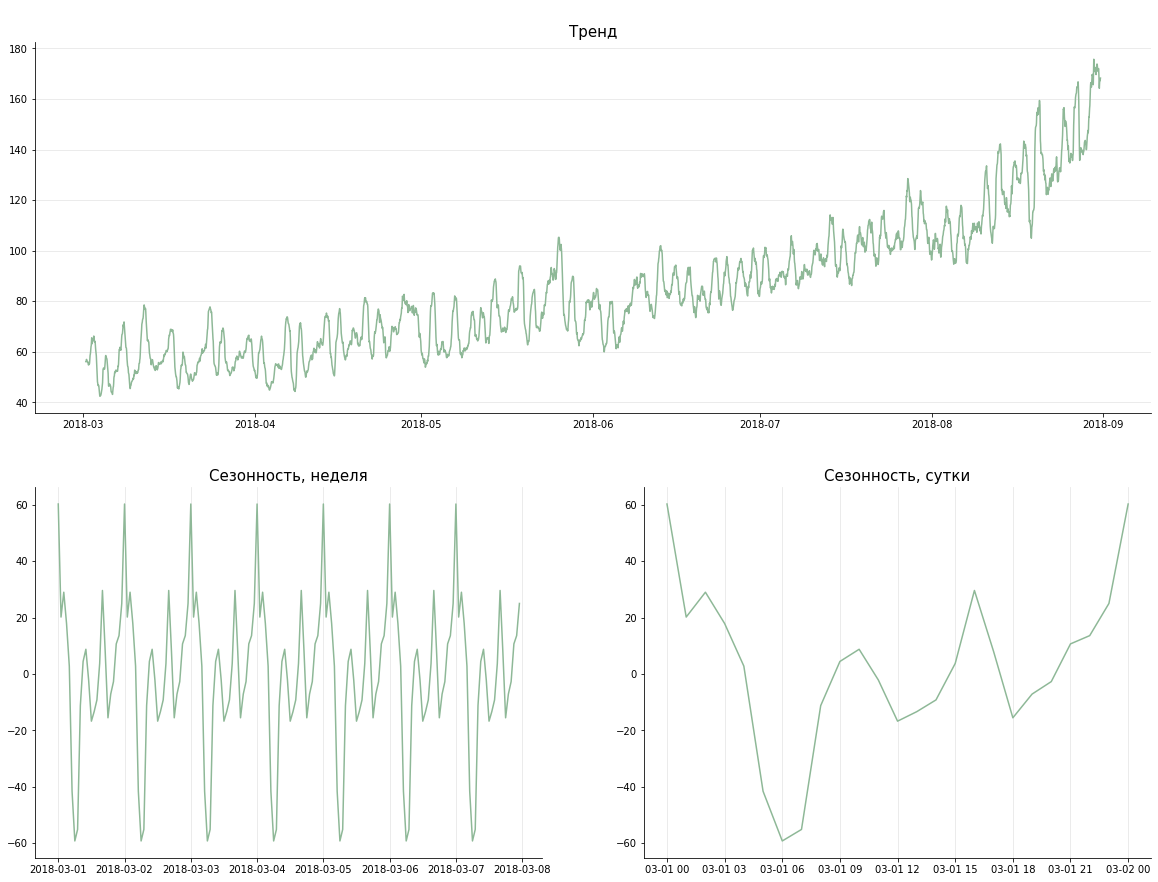

In [7]:
# построим графики трента и сезонности
decomposed = seasonal_decompose(df)

fig = plt.figure(figsize=(20, 15))
ax1, ax2, ax3 = (fig.add_subplot(2, 1, 1),
                 fig.add_subplot(2, 2, 3),
                 fig.add_subplot(2, 2, 4))

ax1.set_title('\nТренд', size=15)
ax1.plot(decomposed.trend, color='#8eb897')
ax1.grid(axis='y', alpha=0.3)

ax2.set_title('\nСезонность, неделя', size=15)
ax2.plot(decomposed.seasonal['2018-03-01':'2018-03-07'], color='#8eb897')
ax2.grid(axis='x', alpha=0.3)

ax3.set_title('\nСезонность, сутки', size=15)
ax3.plot(decomposed.seasonal['2018-03-01 00:00:00':'2018-03-02 00:00:00'], color='#8eb897')
ax3.grid(axis='x', alpha=0.3)

for ax in (ax1, ax2, ax3):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.show()


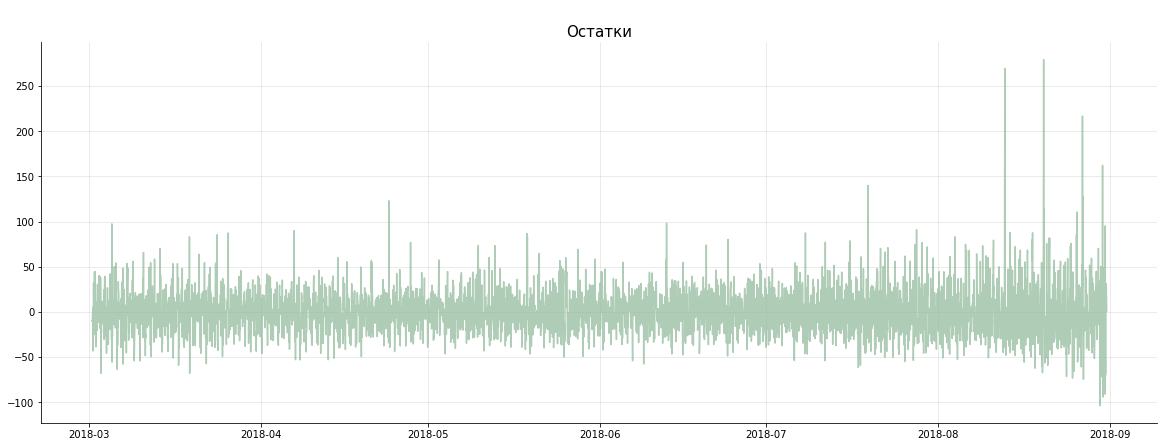

In [8]:
# ознакомимся с графиком остатков
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot()
ax.set_title('\nОстатки', size=15)
ax.plot(decomposed.resid, color='#8eb897', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(alpha=0.3)

plt.show()


In [9]:
# проверим ряд на стационарность с помощью теста Дики-Фуллера
test = adfuller(df['num_orders'])
print(f'adf: {test[0]}')
print(f'p-value: {test[1]}')
print(f'Critical values: {test[4]}')

if test[0] > test[4]['5%']:
    print(f'\nЕсть единичные корни, ряд не стационарен')
else:
    print(f'\nЕдиничных корней нет, ряд стационарен')
    

adf: -3.0689242890279558
p-value: 0.028940051402612906
Critical values: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}

Единичных корней нет, ряд стационарен


### Выводы
1. Построен график изменения количества заказов такси — видно постепенное увеличение заказов;
1. Это подтверждает и график восходящего тренда — с начала весны и до конца лета количество заказов увеличивается. Это может быть связано с расширением бизнеса (ростом пользователей сервиса и парка машин) или с сезоном отпусков — в летние месяцы чаще летают в отпуск и, соответственно, пользуются услугами такси в аэропорту.
1. На графике сезонности видно, что пик заказов приходися на период с 23 до 1 ночи. Минимальное количество заказов с 5 до 7 часов утра.


## Обучение моделей


In [10]:
# напишем функцию cоздания признаков для горизонта прогнозирования в один шаг
def make_features(df, max_lag, rolling_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    df['seasonal'] = decomposed.seasonal
    
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)
        
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_size).mean()
    

In [11]:
# создадим признаки и проверим результат работы функции
# количество отстающих значений примем равным 24, чтобы модель
# "могла посмотреть" как изменяется количество заказов таксти в течение суток
make_features(df, 24, 24)
df.head()


,num_orders,month,day,dayofweek,hour,seasonal,lag_1,lag_2,lag_3,lag_4,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,60.248112,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,20.177074,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,28.982743,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,17.885407,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,2.791145,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# проверим, что количество пропусков равно 24 и удалим объекты с пропусками
print(f'Количество пропусков до обработки: {df.isna().sum().max()}')
df = df.dropna()
print(f'После обработки: {df.isna().sum().sum()}')


Количество пропусков до обработки: 24
После обработки: 0


In [13]:
# разделим данные на обучающую и тестовую выборки в пропорции 90/10
train, test = train_test_split(df, shuffle=False, train_size=0.9)

# проверим корректность результатов разделения
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())


2018-03-02 00:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


In [14]:
# выделим признаки и целевой признак
X_train, y_train = train.drop('num_orders', axis=1), train['num_orders']
X_test, y_test = test.drop('num_orders', axis=1), test['num_orders']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(3952, 30) (3952,)
(440, 30) (440,)


### LinearRegression


In [15]:
lr_model = LinearRegression(fit_intercept=False)


### RandomForestRegressor


In [16]:
rf_model = RandomForestRegressor(max_depth=14,
                                 n_estimators=125,
                                 random_state=12345)


### CatBoostRegressor


In [17]:
cb_model = CatBoostRegressor(depth=6,
                             iterations=150,
                             l2_leaf_reg=1,
                             learning_rate=0.1,
                             random_state=12345,
                             verbose=False)


### LGBMRegressor


In [18]:
lgb_model = LGBMRegressor(n_estimators=125,
                          num_leaves=10,
                          random_state=12345)


### Выводы:
Подобраны гиперпараметры для 4-х моделей:

1. LinearRegression:
  * *по умолчанию*
    * *RMSE: 26.95*  
1. RandomForestRegressor:
  * *max_depth = 14*
  * *n_estimators = 150*
    * *RMSE: 25.28*
1. CatBoostRegressor:
  * *depth = 6*
  * *iterations = 150*
  * *l2_leaf_reg = 1*
  * *learning_rate = 0.1*
    * *RMSE: 24.57*
1. LGBMRegressor:
  * *learning_rate = 0.15*
  * *n_estimators = 75*
  * *num_leaves = 10*
    * *RMSE: 24.63*

## Тестирование

In [19]:
# напишем функцию для тестирования моделей
def test_model(model):
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    rmse = round(mean_squared_error(y_test, prediction, squared=False), 2)
   
    return rmse, prediction


In [20]:
# выведем на экран отчёт с качеством моделей
models = {'LinearRegression': lr_model, 'RandomForestRegressor': rf_model,
          'CatBoostRegressor': cb_model, 'LGBMRegressor': lgb_model}

models_rmse = []
best_rmse = 48
for model in models.values():
    rmse, prediction = test_model(model)
    models_rmse.append(rmse)
    if rmse < best_rmse:
        best_rmse = rmse
        best_prediction = prediction

pd.DataFrame({'Значение метрики RMSE': models_rmse}, index=models.keys())


,Значение метрики RMSE
LinearRegression,43.96
RandomForestRegressor,41.01
CatBoostRegressor,40.67
LGBMRegressor,40.94


In [21]:
# сравним результаты с констрантной моделью
dummy_pred = np.ones(y_test.shape) * y_train.mean()
dummy_rmse = round(mean_squared_error(dummy_pred, y_test, squared=False), 2)

print(f'RMSE константной модели: {dummy_rmse}')


RMSE константной модели: 84.69


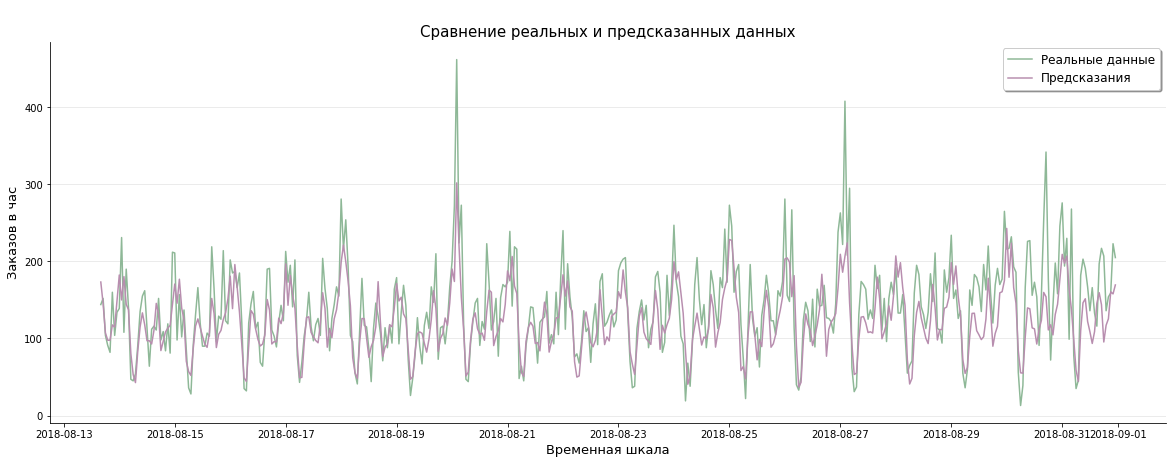

In [22]:
# построим график сравнения реальных и предсказанных данных
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot()
ax.set_title('\nСравнение реальных и предсказанных данных', size=15)
ax.set_xlabel('Временная шкала', size=13)
ax.set_ylabel('Заказов в час', size=13)


ax.plot(X_test.index, y_test, color='#8eb897', label='Реальные данные')
ax.plot(X_test.index, best_prediction, color='#b88eaf', label='Предсказания')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.3)
ax.legend(loc='best', fontsize='large', shadow=True)

plt.show()


<div class="alert alert-success">
<h2> Комментарий ревьюера №2<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Отлично.

### Выводы
1. Задача исследования выполнена — построены модели для прогнозирования количества заказов такси на следующий час
1. Все построенные модели удовлетворяют условию задачи — $RMSE <= 48$
1. Наибольшее качество показала модель **CatBoostRegressor** со значением метрики $RMSE = 40.67$


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
Есть резюме в итоговом выводе.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 
        
Есть еще другие методы работы с временными рядами. Например, Facebook Prophet ( https://facebook.github.io/prophet/ ). Orbit - (https://github.com/uber/orbit)

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

Здесь я оставлю еще несколько интересных и полезных материалов для дополнительного изучения:
        
1. Б.Б. Демешев - временные ряды 
        
https://disk.yandex.ru/i/LiDHB-B3A6Lz5A 


2. Канторович - Анализ временных рядов 

https://yadi.sk/i/IOkUOS3hTXf3gg 

        
        
Так как у тебя очень хорошая визуализация, можно самостоятельно ознакомиться с материалами по Plotly и Bokeh, в случае временных рядов интерактивные графики сильно облегчают анализ, особенно это актуально для финансовых данных.
        

<div class="alert alert-block alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Ксения, ещё раз спасибо за внимательное ревью, я очень тебе благодарен
</div>

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48


<div style="border:solid Chocolate 2px; padding: 40px">
    
<b>Общий вывод по проекту</b>

Дмитрий, благодарю тебя за интересную и содержательную работу! 
У тебя хороший сильный проект.

**Положительные моменты проекта, которые хочу еще раз подчеркнуть**:

    1. Подробный анализ данных, с которыми работаешь,
    2. Прекрасная визуальная составляющая,
    3. Четко выдержана структура проекта,
    4. Обучение моделей и кросс-валидация проведены, учитывая специфику временных данных.
    5. Каждый этап проекта содержит необходимые выводы.
    6. Аккуратность кода на высоком уровне.
    7. Весь код снабжен подробными комментариями.
    8. Ресемплирование по одному часу проведено верно.
    9. Создание признаков выполнено верно.
    10. Есть графики трендат и сезонности на меньшем временном отрезке.


У меня нет серьезных замечаний. Я пока не принимаю работу, чтобы оставить возможность задать вопросы, если они есть. Если вопросов нет, то на следующей итерации я приму твой проект. 
    
Остальные мои комментарии ты найдешь выше.
    
**Желаю удачи и жду твой проект на повторное ревью!**

<div style="border:solid Chocolate 2px; padding: 40px">
    
<b>Дмитрий, спасибо за отличную работу, проект принимаю. Желаю успехов тебе в дальнейшем обучении!</b>
